# **💻 Author Information**

**Name:** CHUA JINGXUAN

**Email:** geochua144@gmail.com

**Note:** This Jupyter Notebook was created by CHUA JINGXUAN. If you find any issues, have questions, or want to provide feedback, please don't hesitate to reach out. Thank you for exploring this notebook!

**Date Written**: 10/09/2025 (WED)

**Last Updated**: 10/09/2025 (WED)

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/Kanon14) <a href="https://www.linkedin.com/in/chua-jingxuan-51a300173" target="_blank" style="margin-left: 10px;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/1/19/LinkedIn_logo.svg" alt="LinkedIn Icon" width="80" height="22">
</a>

---

# 🔬 **VisDrone Training: YOLO12s**

# ⚙️ **1.0 Environment Setup**

## 1.1 Connecting to GPU for Training Acceleration
Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Sep 10 14:15:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   55C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1.2 Installing Ultralytics

In [2]:
%pip install -q ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 39.2/235.7 GB disk)


## 1.3 Import Essential Libraries

In [3]:
import requests
import zipfile
import os
import glob
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image as IPyImage, display

# ⬇️ **2.0 Download VisDrone Image Dataset**

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [4]:
HOME = os.getcwd()
print(HOME)

/content


In [5]:
import gdown

# URL of the file to be downloaded
url = "https://drive.google.com/file/d/141YLcCdD-1j5IGWSvIWKPyRodsXTYASk/view?usp=sharing"
file_id = url.split("/")[-2] # Extract the file ID from the URL
prefix = "https://drive.google.com/uc?/export=download&id=" # Prefix for direct Google Drive download links

# Download the file using gdown
gdown.download(prefix + file_id)
print("Data downloaded!") # Confirm that the download is complete

Downloading...
From (original): https://drive.google.com/uc?/export=download&id=141YLcCdD-1j5IGWSvIWKPyRodsXTYASk
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=141YLcCdD-1j5IGWSvIWKPyRodsXTYASk&confirm=t&uuid=d03d0121-c475-48a8-90ed-9c8b20165b81
To: /content/VisDrone.zip
100%|██████████| 1.95G/1.95G [00:13<00:00, 144MB/s]

Data downloaded!


In [6]:
# Unzip the dataset file and delete the original ZIP file to save storage space
!unzip VisDrone.zip
!rm -rf VisDrone.zip

Streaming output truncated to the last 5000 lines.
  inflating: VisDrone/labels/train/9999943_00000_d_0000092.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000001.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000002.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000003.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000004.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000005.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000006.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000007.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000008.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000009.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000010.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000011.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000012.txt  
  inflating: VisDrone/labels/train/9999945_00000_d_0000013.txt  
  inflating: VisDrone/labels/train/9999

<font color="cyan">VisDrone Dataset Source: [VisDrone.yaml](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/VisDrone.yaml)</font>

**Format:**
```bash
VisDrone/                          # dataset root (yaml["path"])
├─ images/
│  ├─ train/                       # 6,471 images
│  │  ├─ 0000001.jpg
│  │  ├─ 0000002.jpg
│  │  └─ ...
│  ├─ val/                         # 548 images
│  │  ├─ 0000001.jpg
│  │  └─ ...
│  └─ test/                        # 1,610 images (test-dev)
│     ├─ 0000001.jpg
│     └─ ...
└─ labels/
   ├─ train/                       # 6,471 label files (one per image)
   │  ├─ 0000001.txt
   │  ├─ 0000002.txt
   │  └─ ...
   ├─ val/                         # 548 label files
   │  ├─ 0000001.txt
   │  └─ ...
   └─ test/                        # 1,610 label files (from test-dev annotations)
      ├─ 0000001.txt
      └─ ...

```

In [7]:
# Display the contents of the YAML file that contains the configuration or dataset information
%cat VisDrone/data.yaml

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: VisDrone # dataset root dir
train: images/train # train images (relative to 'path') 6471 images
val: images/val # val images (relative to 'path') 548 images
test: images/test # test-dev images (optional) 1610 images

# Classes
names:
  0: pedestrian
  1: people
  2: bicycle
  3: car
  4: van
  5: truck
  6: tricycle
  7: awning-tricycle
  8: bus
  9: motor

# 🛠️ **3.0 Customize YOLO12s Model Training**

In [8]:
# Change the current working directory to the HOME directory
%cd {HOME}

# Train a YOLO11s model for object detection with the specified parameters
!yolo task=detect mode=train \
model=yolo12s.pt \
data={HOME}/VisDrone/data.yaml \
epochs=100 batch=16 lr0=0.001 imgsz=640 patience=10 save_period=10 \
project=visdrone-yolo12s name=train \
plots=True \
exist_ok=True \
save=True

/content
Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/VisDrone/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=Tru

# 🔎 **4.0 Result Analysis**

**NOTE:** The results of the completed training are saved in `{HOME}/visdrone-yolo12s/train`. Let's examine them.

In [9]:
!ls {HOME}/visdrone-yolo12s/train

args.yaml			 labels.jpg		val_batch0_pred.jpg
BoxF1_curve.png			 results.csv		val_batch1_labels.jpg
BoxP_curve.png			 results.png		val_batch1_pred.jpg
BoxPR_curve.png			 train_batch0.jpg	val_batch2_labels.jpg
BoxR_curve.png			 train_batch1.jpg	val_batch2_pred.jpg
confusion_matrix_normalized.png  train_batch2.jpg	weights
confusion_matrix.png		 val_batch0_labels.jpg


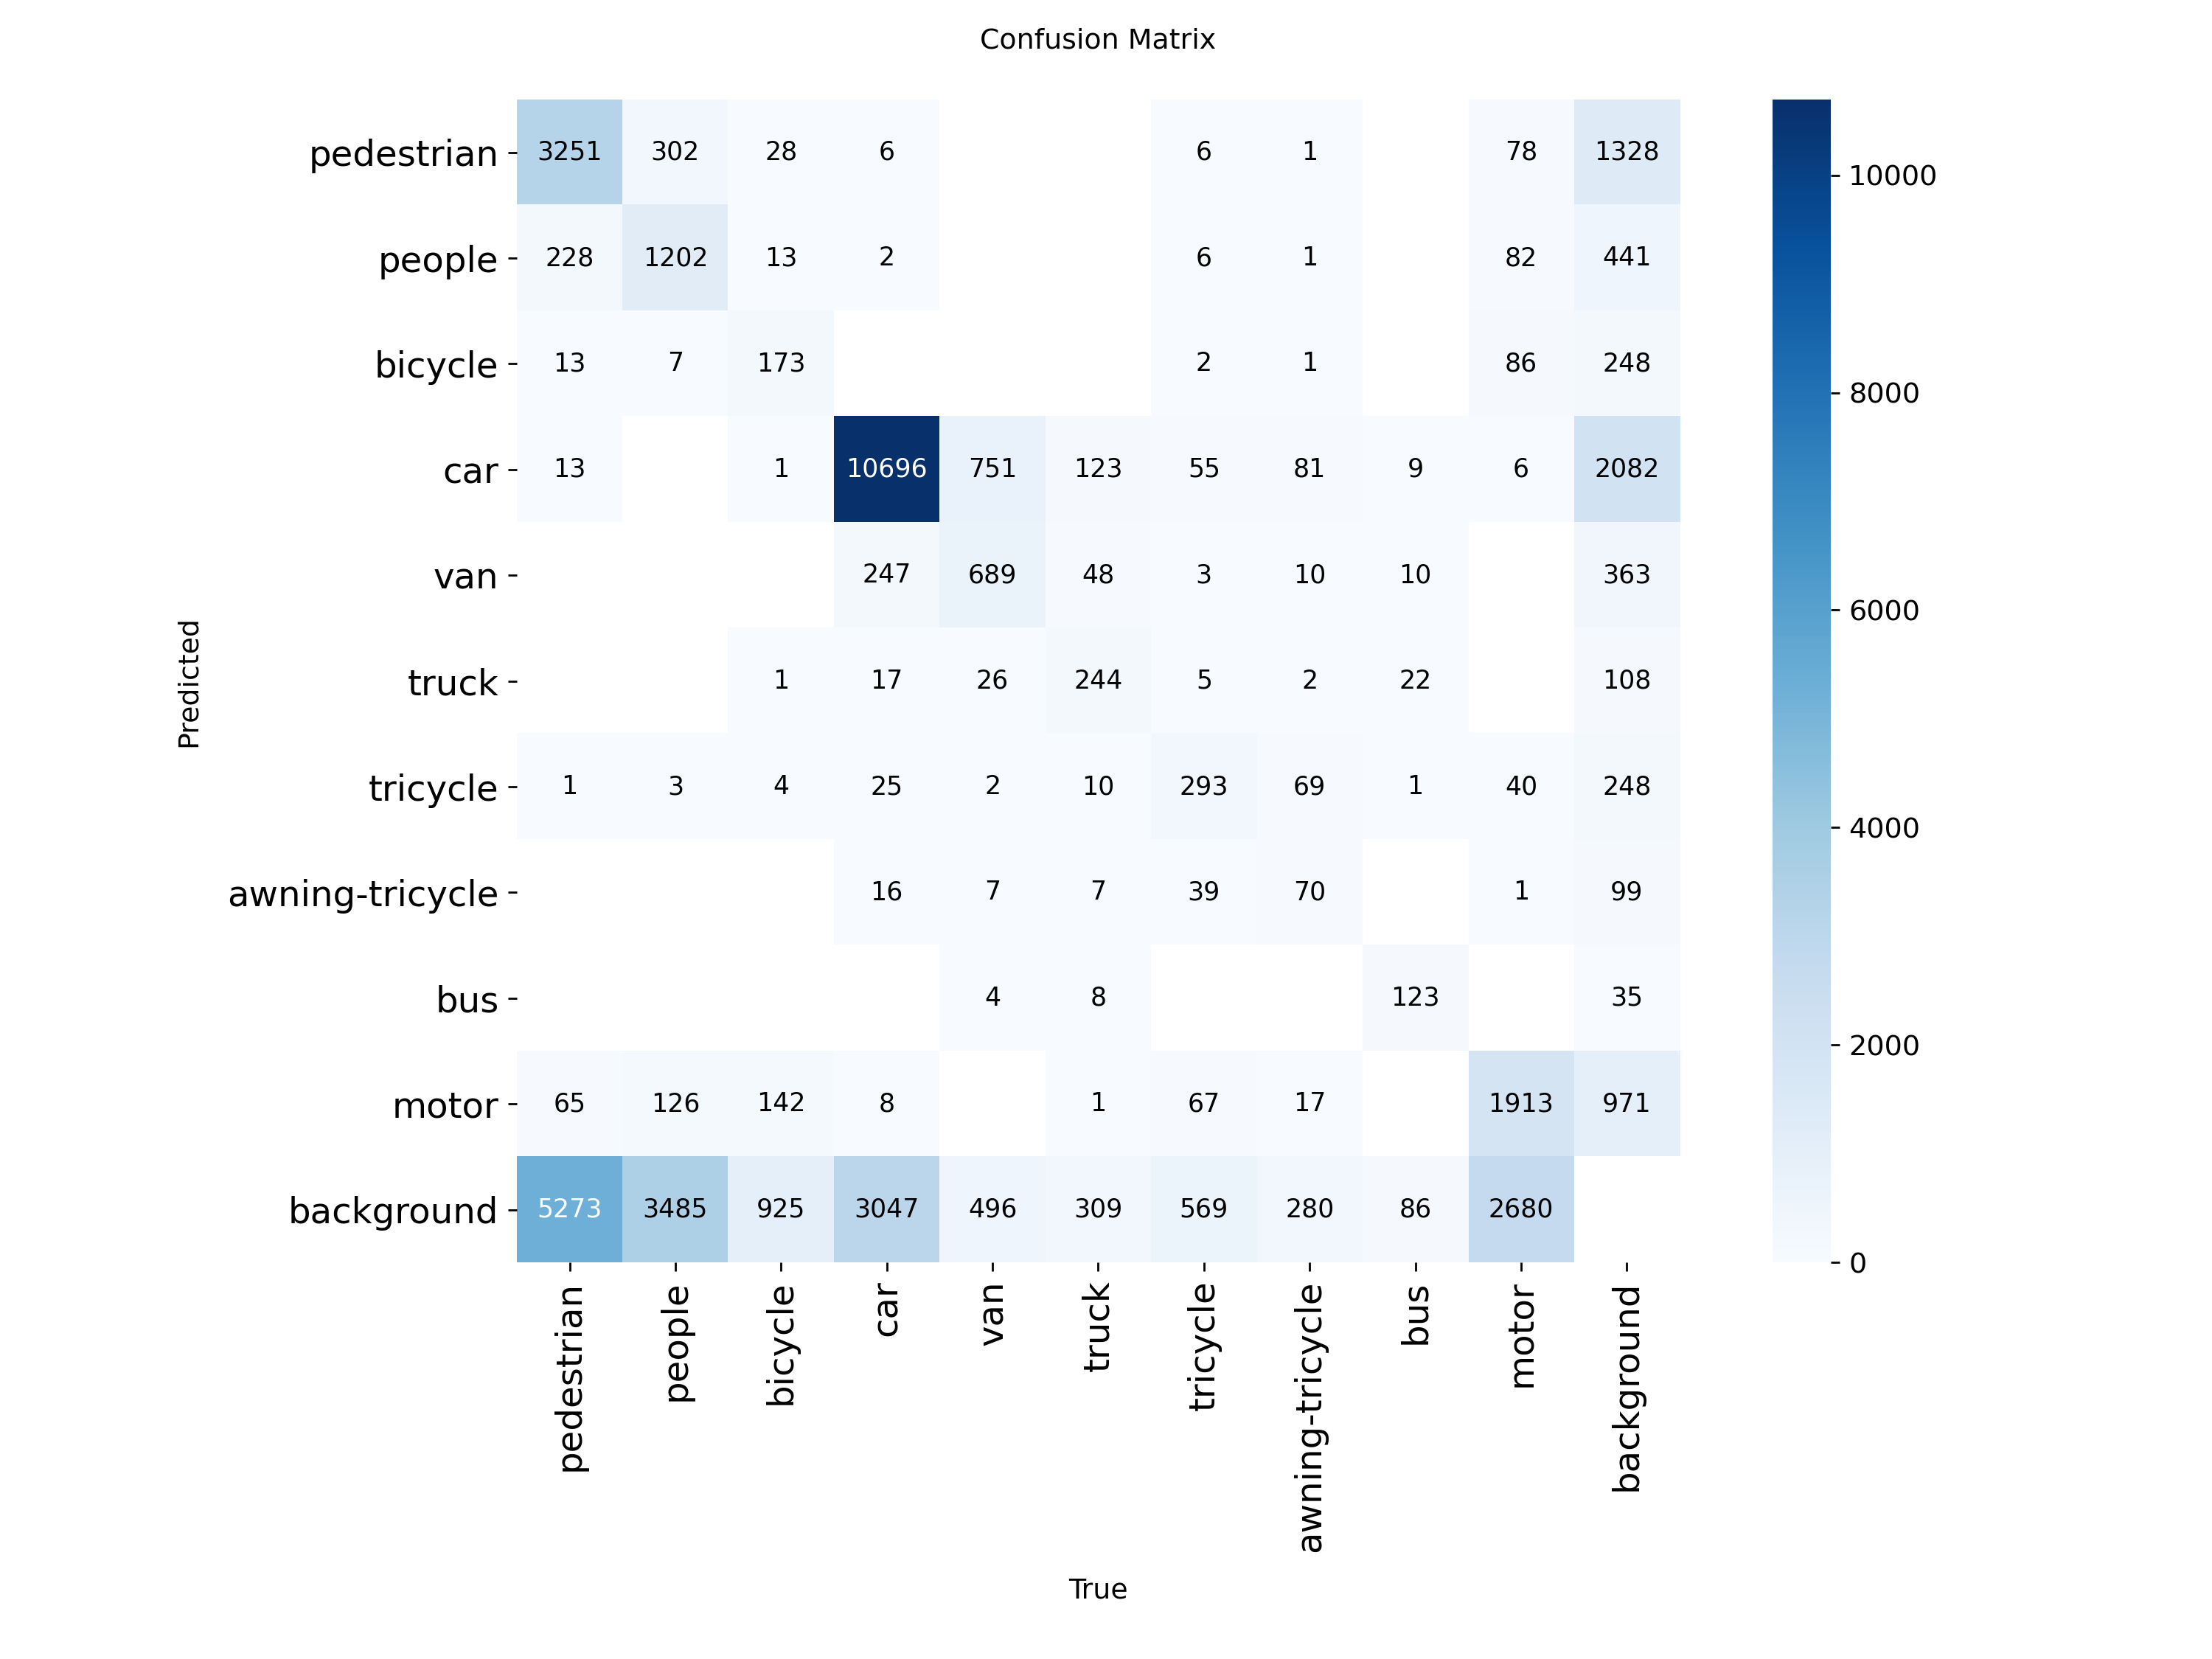

In [10]:
# Display the confusion matrix image generated during the training process
IPyImage(filename=f'{HOME}/visdrone-yolo12s/train/confusion_matrix.png', width=600)

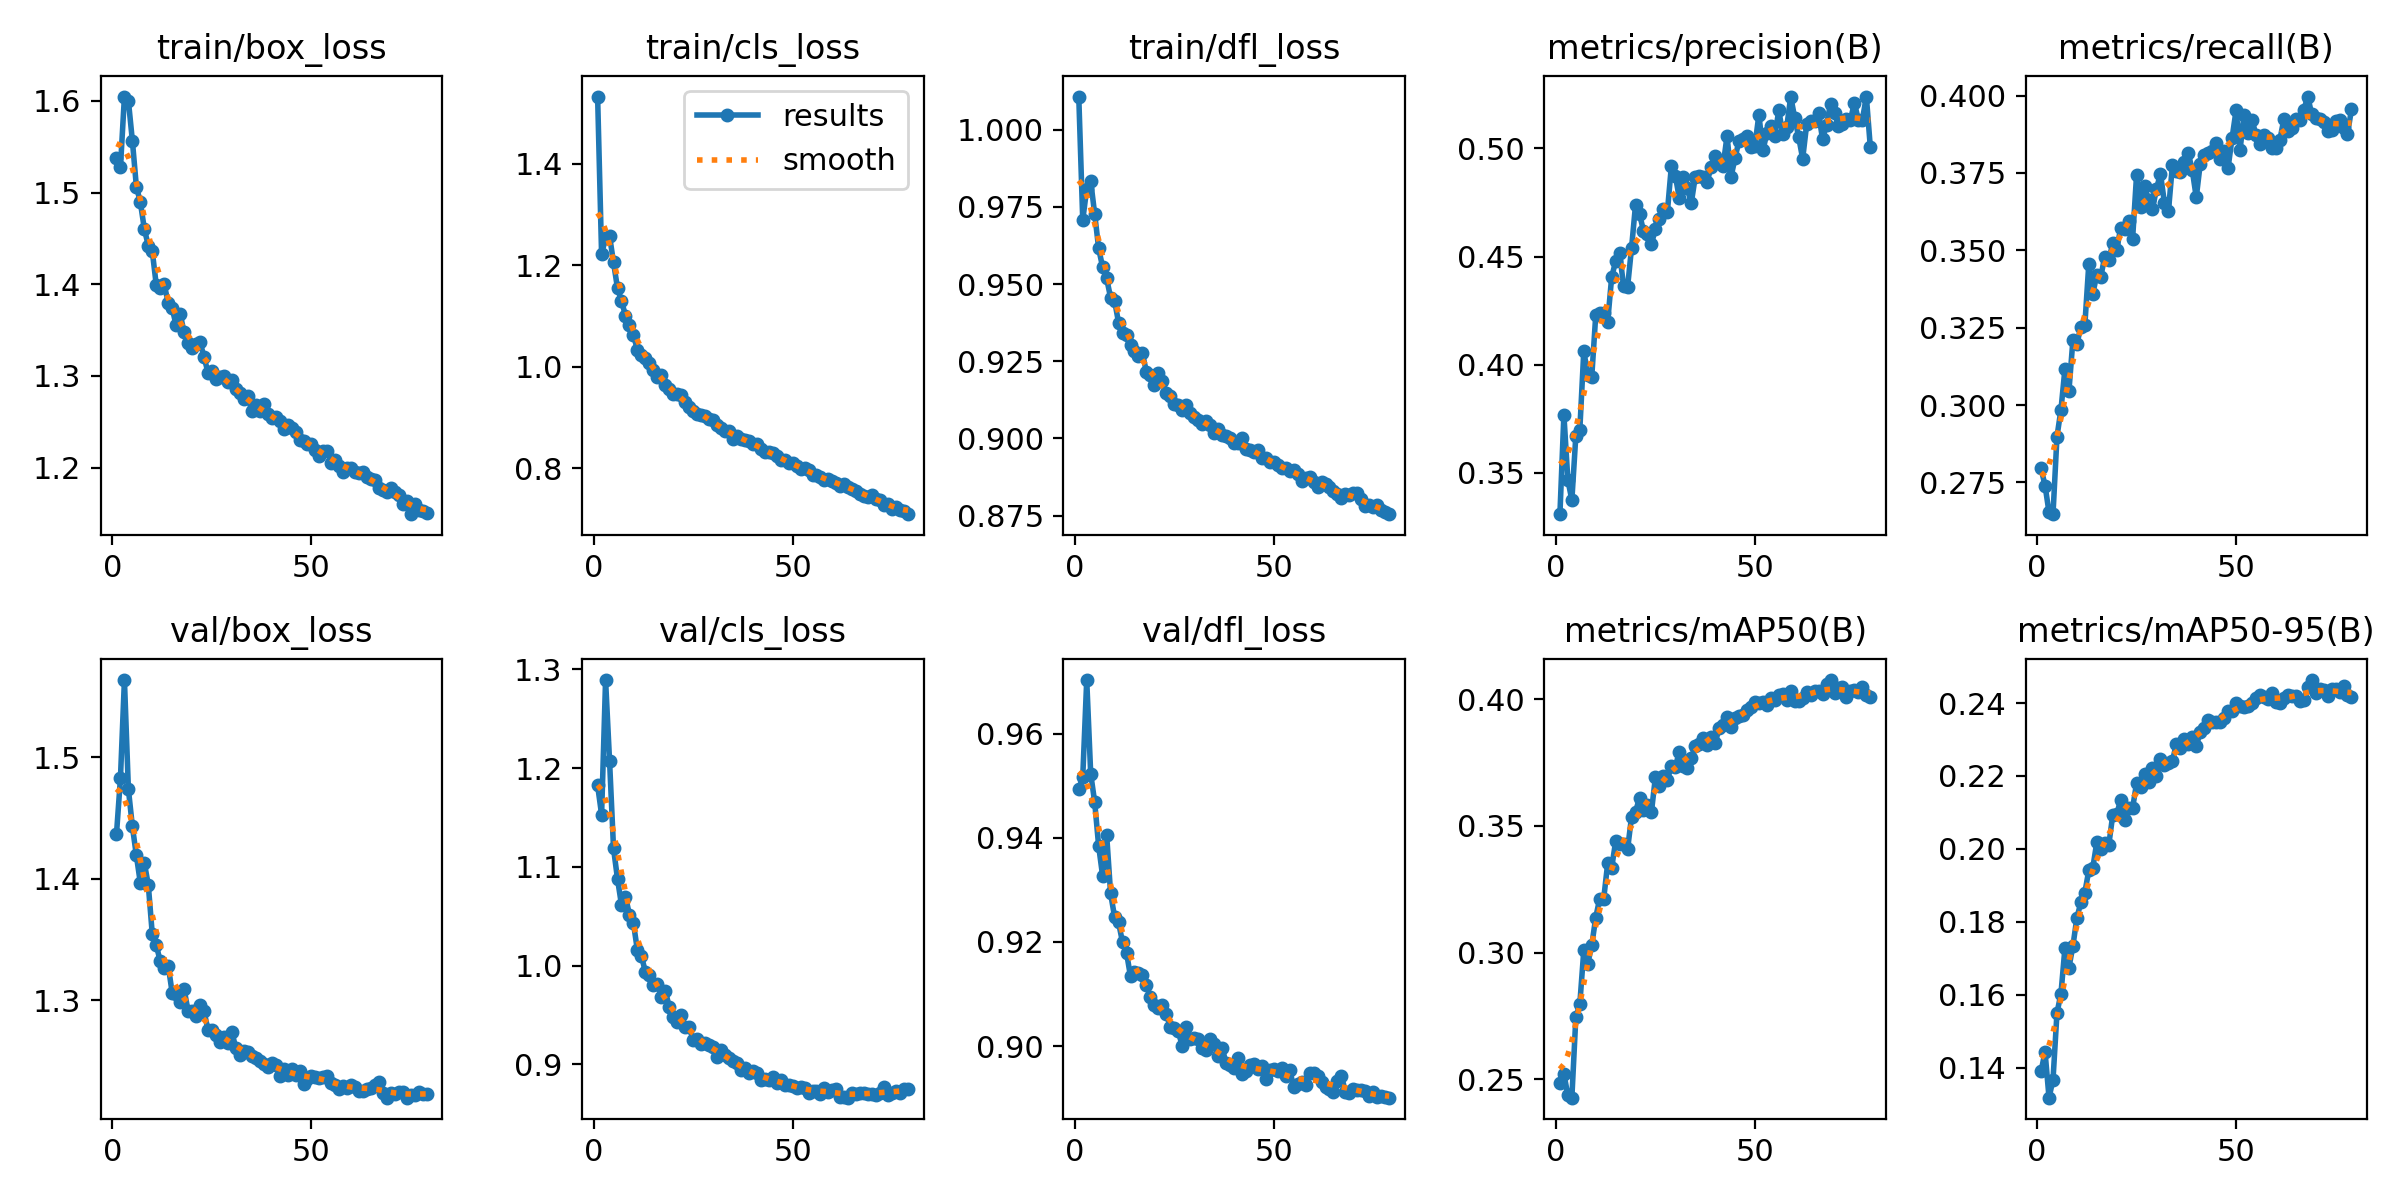

In [11]:
# Display the training results graph, which includes metrics such as loss, precision, recall, and mAP
IPyImage(filename=f'{HOME}/visdrone-yolo12s/train/results.png', width=600)

# 📊 **5.0 Validate Fine-Tuned Model**

In [12]:
# Use the trained YOLO12s model to make predictions on test images
!yolo task=detect mode=predict \
model={HOME}/visdrone-yolo12s/train/weights/best.pt \
conf=0.25 \
source={HOME}/VisDrone/images/test \
project=visdrone-yolo12s \
name=predict \
exist_ok=True \
save=True

Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12s summary (fused): 159 layers, 9,234,750 parameters, 0 gradients, 21.2 GFLOPs

image 1/1610 /content/VisDrone/images/test/0000006_00159_d_0000001.jpg: 384x640 33 cars, 5 vans, 8 trucks, 1 tricycle, 1 motor, 85.5ms
image 2/1610 /content/VisDrone/images/test/0000006_00611_d_0000002.jpg: 384x640 1 pedestrian, 2 peoples, 37 cars, 4 vans, 7 trucks, 1 awning-tricycle, 3 motors, 14.1ms
image 3/1610 /content/VisDrone/images/test/0000006_01111_d_0000003.jpg: 384x640 2 pedestrians, 1 people, 12 cars, 2 trucks, 4 motors, 13.7ms
image 4/1610 /content/VisDrone/images/test/0000006_01275_d_0000004.jpg: 384x640 1 pedestrian, 13 cars, 5 trucks, 4 motors, 13.6ms
image 5/1610 /content/VisDrone/images/test/0000006_01659_d_0000004.jpg: 384x640 6 cars, 38 trucks, 13.7ms
image 6/1610 /content/VisDrone/images/test/0000006_02138_d_0000006.jpg: 384x640 3 cars, 43 trucks, 13.8ms
image 7/1610 /content/VisDrone/images/test/0

In [13]:
# Plot and visualize images in a 1x1 or 2x2 grid, based on the number of images available
def visualize(result_dir):
    """
    This function accepts a directory path containing images and visualizes them
    - If there are fewer than 4 images, it plots them in a 1x1 grid.
    - If there are 4 or more images, it plots them in a 2x2 grid.
    """

    image_names = glob.glob(os.path.join(result_dir, '*.jpg')) # Get all JPG image file paths from the directory
    if len(image_names) < 4:
        plt.figure(figsize=(10, 7)) # Create a figure for fewer than 4 images
        for i, image_name in enumerate(image_names):
            image = plt.imread(image_name)
            plt.subplot(1, 1, i+1) # Create a 1x1 subplot for each image
            plt.imshow(image)
            plt.axis('off')
            break
    if len(image_names) >= 4:
        plt.figure(figsize=(15, 12)) # Create a figure for 4 or more images
        for i, image_name in enumerate(image_names):
            image = plt.imread(image_name)
            plt.subplot(2, 2, i+1) # Create a 2x2 subplot for the first 4 images
            plt.imshow(image)
            plt.axis('off')
            if i == 3: # Stop after plotting 4 images
                break

    plt.suptitle('Inference Results', fontsize=20) # Set the title of the plot
    plt.tight_layout() # Adjust the layout for better spacing
    plt.show() # Display the plot

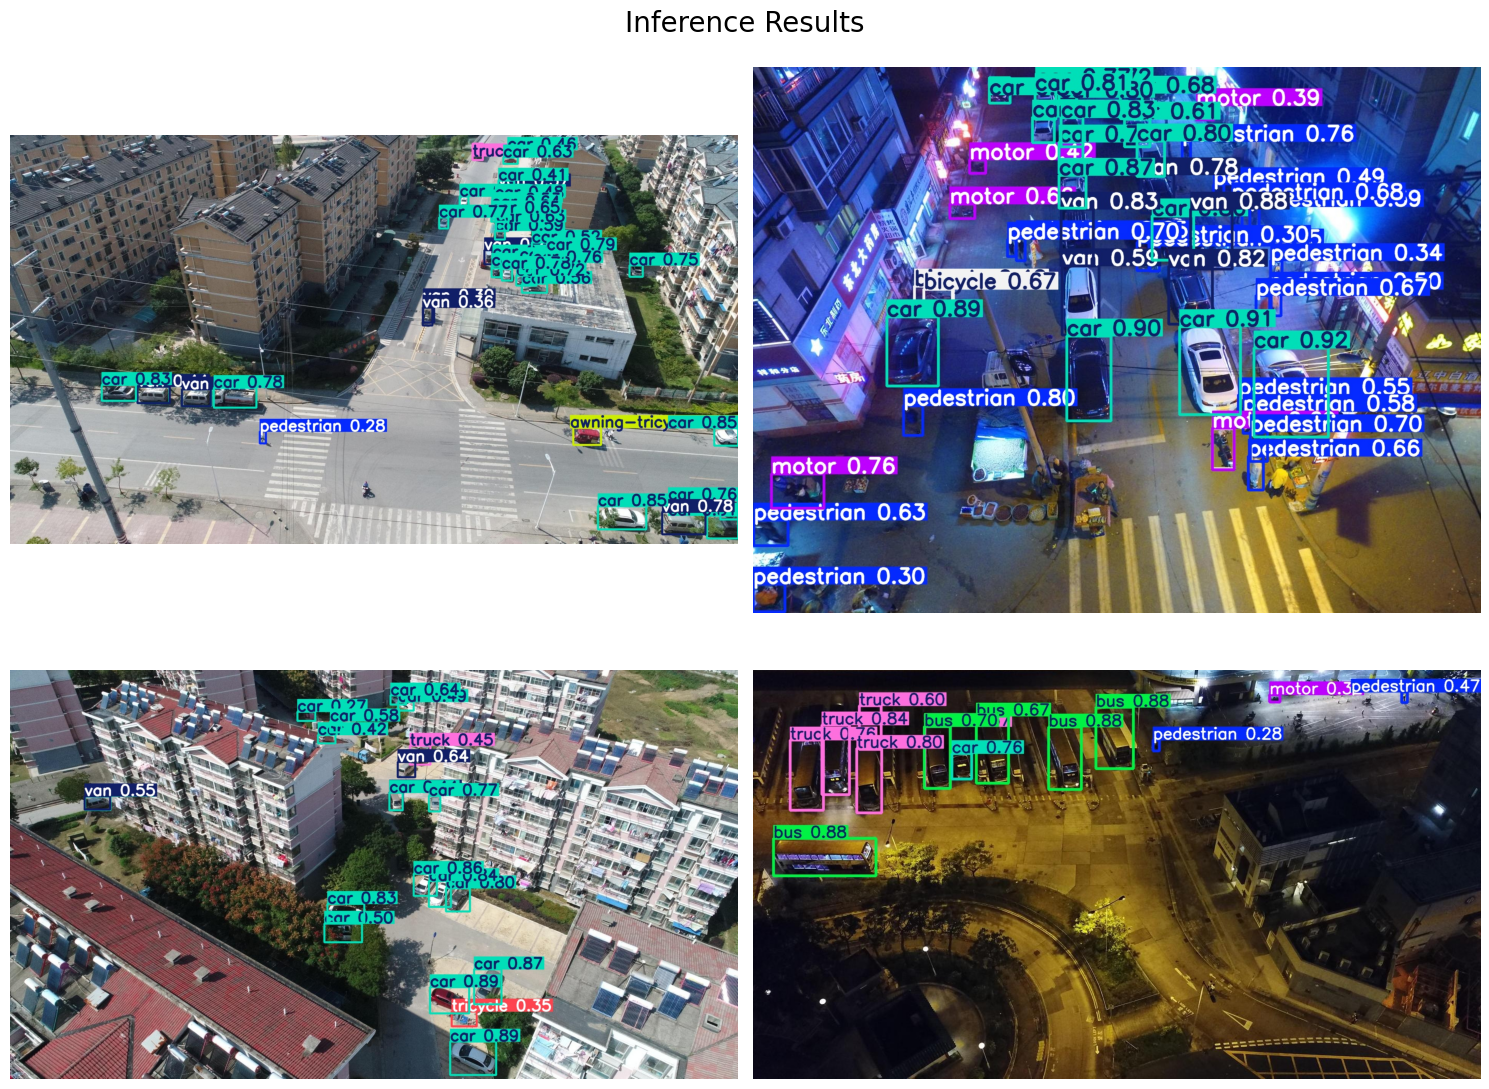

In [14]:
# Call the visualize function to display prediction results
visualize('/content/visdrone-yolo12s/predict')

# **📂 Compress and Download Folder**
This section zips the `visdrone-yolo12s` folder and provides a downloadable file for local storage or further use. The steps include:

* Compressing the folder into a `.zip` archive.
* Automatically initiating the download of the zipped file.

In [15]:
import shutil
from google.colab import files

# Define the folder name and output ZIP file name
folder_name = "visdrone-yolo12s"
zip_file_name = f"{folder_name}.zip"

# Zip the folder
shutil.make_archive(folder_name, 'zip', folder_name)

# Download the zipped folder
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 🌟 **End of the YOLO12s Training**